# Experiment: EEG classification with Deep Learning - CNN-1D

In this experiment, a multitask model simultaneously performs two types of classifications from EEG data. The objective is to identify the frequency (frequency rating) used to generate the SSVEP signal. Additionally, the model was also trained to verify if the signal was actually generated from SSVEP (task classification).
The data used are divided into training and validation data to train the model, and into test data to evaluate the classification performance of the trained model.

# Signal preprocessing

The folowing preprocessing steps are applied to the EEG signal data:
1. Normalization

The normalization step is applied during the training while windowing have already been applied to the raw data. 

# The classification

In the task classification, EEG signals is classified with 1 if it is SSVEP and with 0 otherwise. If the signal is SSEVP, the frequency classification indicates which frequence was used to generate it. The possible frequencies are: 0, 5.45, 6.67, 8.57, 12. Frequency 0 is also used to indicate whether the EEG signal is not SSVEP.

## Table of Contents

- [0. Import libraries](#0)
- [1. Config Variables and hyperparameters](#1)
- [2. Load dataset with dataloader](#2)
- [3. Create model](#3)
- [4. Training](#4)
- [5. Evaluate best model](#5)

<a name="0"></a>
# Import Libraries

In [29]:
import os, sys

processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EEGDataGenRaw import EEGDataGen

utils_source_path = os.path.abspath('./../../../Utils/')
if(utils_source_path not in sys.path):
    sys.path.append(utils_source_path)
import utils as utils

from keras.utils.layer_utils import count_params
model_source_path = os.path.abspath('./../../../Keras_deep_models/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
from conv1D_raw_multiclass_model_multitask import CONV1DRAW, weighted_categorical_crossentropy


In [30]:
# sys.path.append('/root/Bioproject/functions')

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    zero_one_loss,
    classification_report,
)
from bpmll import bp_mll_loss

import warnings
warnings.filterwarnings('ignore')


In [32]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


<a name="1"></a>
# Config Variables and hyperparameters

In [5]:
params = {
    'dataset_path':'/root/data/data/EEG/MNE-lee2019_ssvep-data/',
    'h5_file_name_train':'/root/data/data/EEG/RAW/lee2019_ssvep_mi_raw_train_no_filters.h5py',
    'model_checkpoint_path' : "./trained_models/",
    'extracted_frequencies': [4,44],
    'features_type': 'raw',
    'preprocessing': 'norm_by_channel',
    'num_channels': 8,
    'num_classes':  5,
    'num_samples': 512,
    'num_heights': 16,
    'window_size': 512,
    'window_step': 16,
    'batch_size': 64,
    'epochs': 200,
    'dropout_rate': 0.5,
    'output_function': 'activations.softmax',
    'model_name': 'SSVEP_CNN_1D_minmax_normalized_by_channel_data_Raw_multihead_dataloader_weights',
    'neurons_conv': [64,128],
    'neurons_dense': [512,256],
    'print_model': True,
    'norm_axis': 1,
    'sampling_rate':1000,
    'freqs': [0, 12.0, 8.57, 6.67, 5.45],
    'use_class_weights':True
}

<a name="1-1"></a>
# Custom dataloader and pre-processing

In [6]:
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(axis=params['norm_axis']),  
    #pp.AxisPermutation([1,0,2]),  
]) # 8 channels per 60 freqs samples 

In [7]:
print('Model name',params['model_name'])


Model name SSVEP_CNN_1D_minmax_normalized_by_channel_data_Raw_multihead_dataloader_weights


<a name="1-1-1"></a>
## Split data in train, validation and test

In [8]:
with h5py.File(params['h5_file_name_train'], 'r') as hf:
    print(hf.keys())
    print(hf['label'][...].shape)
    print(hf['eeg'][...].shape)
    subjects=hf['subject'][...]
    y=hf['eeg'][...]
    
#x = np.arange(len(y))
x=np.arange(len(np.arange(0, y.shape[0]-params['window_size']+1, params['window_step'])))
x_full_train, idx_x_val, y_full_train, y_val = train_test_split(x, x, test_size=0.3, random_state=42)
idx_x_train, idx_x_test, y_train, y_test = train_test_split(x_full_train, y_full_train, test_size=0.3, random_state=42)
# rever isso 

<KeysViewHDF5 ['eeg', 'ep_flag', 'label', 'session', 'subject']>
(8300,)
(8300, 8, 4000)


In [9]:
selected_subjects=np.delete(np.unique(subjects),[9,19,29,39,49]) 
get_subjects_indices = np.array([i for i, valor in enumerate(subjects) if valor in selected_subjects])
#np.unique(subjects[get_subjects_indices])

<a name="2"></a>
# Load dataset with dataloader

In [10]:
def train_val_test_split(h5_file_name, random_state=42, label_name='label', split_twice=True, get_subjects=None):
    
    with h5py.File(h5_file_name, 'r') as hf:        
        y = hf[label_name][...]
        y_task = hf['ep_flag'][...]
        
        if get_subjects is not  None:
            y = y[get_subjects]
            y_task = y_task[get_subjects]
        y = np.hstack((y.reshape((-1, 1)), y_task.reshape((-1, 1))))
     
    x = np.arange(y.shape[0])
    
    x_full_train, x_val, y_full_train, y_val = train_test_split(x, y, test_size=0.3, random_state=random_state, stratify=y)
    
    if(split_twice):
        x_train, x_test, y_train, y_test = train_test_split(x_full_train, y_full_train, test_size=0.3, random_state=random_state, stratify=y_full_train)
    
    if(split_twice):
        return x_train, x_val, x_test, y
    else:
        return x_full_train, x_val, y

In [11]:
x_train, x_val, x_test, y= train_val_test_split(params['h5_file_name_train'], random_state=42, label_name='label',split_twice=True, get_subjects=get_subjects_indices)

<a name="2-1"></a>
## Get train, val and test dataloader

In [12]:
train_loader = EEGDataGen(params['h5_file_name_train'], x_train, batch_size=params['batch_size'], 
                      window_size=params['window_size'], window_step=params['window_step'], num_channels=params['num_channels'],
                      processing=data_processing, fft =False, sfreq=params['sampling_rate'])

In [13]:
val_loader = EEGDataGen(params['h5_file_name_train'], x_val, batch_size=params['batch_size'], 
                      window_size=params['window_size'], window_step=params['window_step'], num_channels=params['num_channels'],
                      processing=data_processing, fft =False, sfreq=params['sampling_rate'])

In [14]:
test_loader = EEGDataGen(params['h5_file_name_train'], x_test, batch_size=params['batch_size'], 
                      window_size=params['window_size'], window_step=params['window_step'], num_channels=params['num_channels'],
                      processing=data_processing, fft =False, sfreq=params['sampling_rate'])

<a name="2-2"></a>
## Preview Data 

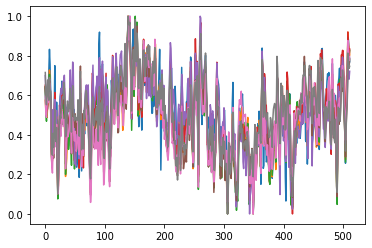

In [15]:
plt.plot(train_loader.__getitem__(5)[0][0])
plt.show()

<a name="2-3"></a>
## Comput class weights for imbalanced database

In [16]:
comput_class_weights_from_dataloader= False
if comput_class_weights_from_dataloader:
    y_freq = []
    y_task = []
    for data,[y_f, y_t] in tqdm(train_loader):
        y_freq+=[y_f]
        y_task+=[y_t]
    y_freq=np.array(y_freq)

    freq_class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(np.argmax(np.vstack(y_freq),axis=1)),
                                                     np.argmax(np.vstack(y_freq),axis=1).tolist())

    task_class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(np.argmax(np.vstack(y_task),axis=1)),
                                                     np.argmax(np.vstack(y_task),axis=1).tolist())
    del y_freq, y_task

In [17]:
freq_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(5), y=y[x_train][:,0])
task_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(2), y=y[x_train][:,1])

In [18]:
loss_freq=weighted_categorical_crossentropy(freq_class_weights)
freq_class_weights

array([0.32765957, 2.05613079, 2.05054348, 2.05613079, 2.05054348])

In [21]:
loss_task=weighted_categorical_crossentropy(task_class_weights)
task_class_weights

array([0.81914894, 1.28333333])

<a name="3"></a>
# Deep-Learning Model

<a name="3-1"></a>
## Create model

In [22]:
# random_states = [21, 42, 63, 84, 105]
random_states = [21, 105]

#model_name='SSVEP_CNN_1D_BatchNormalization_log10'
factors = [1,2,3]
Ds = [1,2,3]

opts_id = [0, 1, 2, 3]
opt_log = ['Adam', 'AdamW', 'AdamW2', 'SGD']
lr_log = ['0.00001', '0.00001', '0.001', '0.00001']

rs = random_states[0]
opt_ind = opts_id[2]
nc = np.arange(len(factors))[0]
nd = np.arange(len(Ds))[0]

optimizer1 =  tf.optimizers.Adam(learning_rate=float(lr_log[0]), beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
optimizer2 = tfa.optimizers.AdamW(learning_rate=float(lr_log[1]), weight_decay=2e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
optimizer3 = tfa.optimizers.AdamW(learning_rate=float(lr_log[2]), weight_decay=2e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
optimizer4 =  tf.optimizers.SGD(learning_rate=float(lr_log[3]), momentum=0.9, nesterov=True)

opts_list = [optimizer1, optimizer2, optimizer3, optimizer4]
opt = opts_list[opt_ind]

model_name = params['model_checkpoint_path'] +params['model_name']+'/'+opt_log[opt_ind]+lr_log[opt_ind]+'_factor'+str(factors[nc])+'_D'+str(Ds[nd])
#S1_'+str(rs)+'_'+opt_log[opt_ind]+lr_log[opt_ind]+'_factor'+str(factors[nc])+'_D'+str(Ds[nd])

# Create the CNN
CNN1D = CONV1DRAW(model_path=params['model_checkpoint_path'], checkpoint_filepath= model_name, factor=factors[nc], D=Ds[nd], params=params, print_model=True)
model = CNN1D.load_model()

if not params['use_class_weights']:
    model = CNN1D.compile_model(model, custom_optimizer=opt)
else:
    model = CNN1D.compile_model(model, opt, weight_freq=freq_class_weights, weight_task=task_class_weights)

trainable_count =  count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

path False
Unable to open file ./trained_models/SSVEP_CNN_1D_minmax_normalized_by_channel_data_Raw_multihead_dataloader_weights/AdamW20.001_factor1_D1 . Creating a new model.
Model: "multitask"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 8)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 512, 64)      1600        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
              

<a name="3-2"></a>
## Trainig the Model

In [21]:
history = CNN1D.train(model, train_loader, test_loader)
del model

Epoch 1/200


2023-11-10 14:50:51.028936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2023-11-10 14:50:51.912498: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12910/12910 [==============================] - ETA: 0s - loss: 1.1402 - freq_output_loss: 0.7616 - task_output_loss: 0.3786 - freq_output_categorical_accuracy: 0.6905 - task_output_categorical_accuracy: 0.8274

2023-11-10 15:14:24.963869: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./trained_models/SSVEP_CNN_1D_minmax_normalized_by_channel_data_Raw_multihead_dataloader_weights/AdamW20.001_factor1_D1/assets
12910/12910 [==============================] - 1419s 110ms/step - loss: 1.1402 - freq_output_loss: 0.7616 - task_output_loss: 0.3786 - freq_output_categorical_accuracy: 0.6905 - task_output_categorical_accuracy: 0.8274 - val_loss: 1.2785 - val_freq_output_loss: 0.8485 - val_task_output_loss: 0.4300 - val_freq_output_categorical_accuracy: 0.5453 - val_task_output_categorical_accuracy: 0.7552 - lr: 0.0010
Epoch 2/200
12910/12910 [==============================] - 1413s 109ms/step - loss: 0.7724 - freq_output_loss: 0.5197 - task_output_loss: 0.2527 - freq_output_categorical_accuracy: 0.7976 - task_output_categorical_accuracy: 0.8941 - val_loss: 0.9841 - val_freq_output_loss: 0.6682 - val_task_output_loss: 0.3159 - val_freq_output_categorical_accuracy: 0.6214 - val_task_output_categorical_accuracy: 0.8419 - lr: 0.0010
Epoch 3/200


<a name="3-3"></a>
## Evaluate history performance

In [ ]:
history.history.keys()

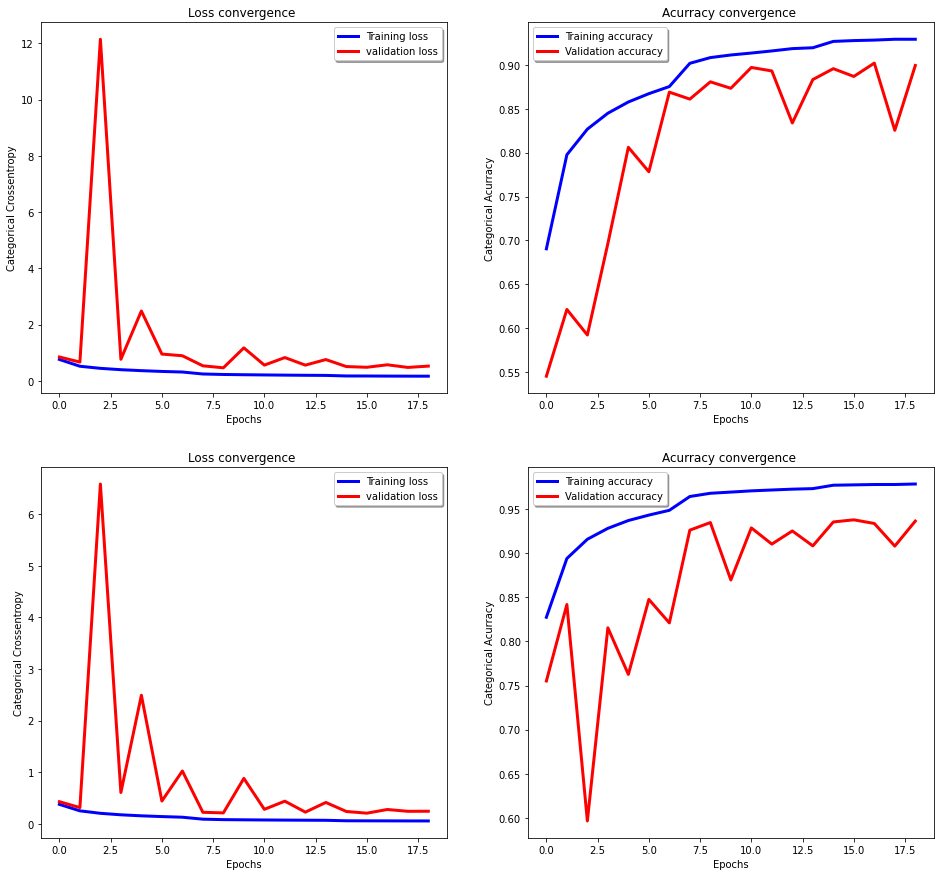

<Figure size 432x288 with 0 Axes>

In [25]:
def plot_history(history, model_checkpoint_path):
    '''Plots Model History

        Args:
            history (object): Model Training History, has Training/Validation accuracy and loss over passage of epochs 
            model_checkpoint_path (str): Model Saving Path 
    '''
    fig, ax = plt.subplots(2,2, figsize=(16,15))

    ax[0,0].plot(history.history['freq_output_loss'], color='b', label="Training loss",linewidth=3)
    ax[0,0].plot(history.history['val_freq_output_loss'], color='r', label="validation loss",linewidth=3)
    ax[0,0].set_title("Loss convergence ")
    ax[0,0].set_xlabel("Epochs")
    ax[0,0].set_ylabel('Categorical Crossentropy')
    legend = ax[0,0].legend(loc='best', shadow=True)


    ax[0,1].plot(history.history['freq_output_categorical_accuracy'], color='b', label="Training accuracy",linewidth=3)
    ax[0,1].plot(history.history['val_freq_output_categorical_accuracy'], color='r',label="Validation accuracy",linewidth=3)
    ax[0,1].set_title("Acurracy convergence ")
    ax[0,1].set_ylabel("Categorical Acurracy")
    ax[0,1].set_xlabel("Epochs")

    legend = ax[0,1].legend(loc='best', shadow=True)


    ax[1,0].plot(history.history['task_output_loss'], color='b', label="Training loss",linewidth=3)
    ax[1,0].plot(history.history['val_task_output_loss'], color='r', label="validation loss",linewidth=3)
    ax[1,0].set_title("Loss convergence ")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel('Categorical Crossentropy')
    legend = ax[1,0].legend(loc='best', shadow=True)


    ax[1,1].plot(history.history['task_output_categorical_accuracy'], color='b', label="Training accuracy",linewidth=3)
    ax[1,1].plot(history.history['val_task_output_categorical_accuracy'], color='r',label="Validation accuracy",linewidth=3)
    ax[1,1].set_title("Acurracy convergence ")
    ax[1,1].set_ylabel("Categorical Acurracy")
    ax[1,1].set_xlabel("Epochs")

    legend = ax[1,1].legend(loc='best', shadow=True)
    plt.show()
    
    if params['model_checkpoint_path'] != None:
        plt.savefig(params['model_checkpoint_path']+'/Train_validatin_model.png')
    #plt.savefig('Figures/'+params['model_checkpoint_path'].split('/')[-1]+': Train_validatin_model.png')

plot_history(history, model_checkpoint_path=None)

In [ ]:
keys=['loss','freq_output_categorical_accuracy','task_output_categorical_accuracy']
utils.plot_history_keys(log_data,keys, None)

<a name="4"></a>
# Evaluate best model

In [24]:
import keras
if not params['use_class_weights']:
    model = tf.keras.models.load_model(model_name)
else:
    model = keras.models.load_model(model_name,custom_objects={'loss':{'freq_output': loss_freq, 
                                                            'task_output': loss_task}})
#save the best model in H5 extension
model.save(params['model_checkpoint_path']+"/"+model_name+".h5")

In [25]:
params['model_checkpoint_path']

'./trained_models/'

In [26]:
model_name

'./trained_models/SSVEP_CNN_1D_minmax_normalized_by_channel_data_Raw_multihead_dataloader_weights/AdamW20.001_factor1_D1'

<a name="4-1"></a>
## Peformance on Train Data 

In [33]:
train_performance=model.evaluate(train_loader)
train_performance

12910/12910 [==============================] - 970s 75ms/step - loss: 0.1484 - freq_output_loss: 0.1069 - task_output_loss: 0.0415 - freq_output_categorical_accuracy: 0.9528 - task_output_categorical_accuracy: 0.9882


[0.14836789667606354,
 0.1068936139345169,
 0.0414741225540638,
 0.9527667760848999,
 0.9881874322891235]

<a name="4-2"></a>
## Peformance on Val Data 

In [34]:
val_performance=model.evaluate(val_loader)
val_performance

7904/7904 [==============================] - 594s 75ms/step - loss: 0.7384 - freq_output_loss: 0.4988 - task_output_loss: 0.2395 - freq_output_categorical_accuracy: 0.8737 - task_output_categorical_accuracy: 0.9266


[0.7383571863174438,
 0.498833566904068,
 0.23952476680278778,
 0.8736557364463806,
 0.9265798926353455]

<a name="4-3"></a>
## Peformance on Test Data 

In [33]:
test_performance=model.evaluate(test_loader)
test_performance

5533/5533 [==============================] - 434s 78ms/step - loss: 0.6774 - freq_output_loss: 0.4645 - task_output_loss: 0.2129 - freq_output_categorical_accuracy: 0.8807 - task_output_categorical_accuracy: 0.9348


[0.677447497844696,
 0.4645448625087738,
 0.21290168166160583,
 0.8807326555252075,
 0.9347748756408691]

In [27]:
y_freq, y_task, y_pred_freq, y_pred_task= utils.generate_data_multihead(test_loader, model)

  0%|          | 0/5533 [00:00<?, ?it/s]2023-11-13 17:49:51.655517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2023-11-13 17:49:52.425356: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 5533/5533 [14:37<00:00,  6.31it/s]


[0.677447497844696, 0.4645448625087738, 0.21290168166160583, 0.8807326555252075, 0.9347748756408691]
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93    206071
         1.0       0.85      0.86      0.86     40295
         2.0       0.89      0.85      0.87     34383
         3.0       0.80      0.87      0.84     33944
         4.0       0.66      0.82      0.73     39419

    accuracy                           0.88    354112
   macro avg       0.83      0.86      0.84    354112
weighted avg       0.89      0.88      0.88    354112

Accuracy Score : 0.8807298255919032
Precision Score : 0.8326532953988973
Recall Score : 0.8599691389740262
F1-Score : 0.8440550194676882


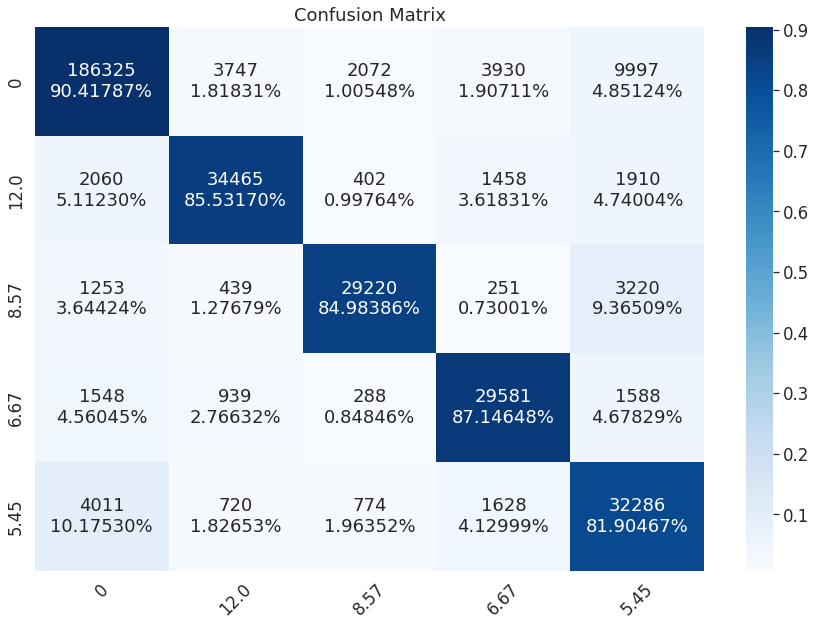

In [34]:
gesture_list=np.unique(y_freq)
utils.plot_confusion_matrix(y_freq.reshape(-1,1), y_pred_freq.reshape(-1,1), params['freqs'], params['model_checkpoint_path'])

test_precision=precision_score(y_freq, y_pred_freq, pos_label='positive', average='macro')
test_recall=recall_score(y_freq, y_pred_freq, pos_label='positive',average='macro')
test_f1_score=f1_score(y_freq, y_pred_freq,average='macro')

print(test_performance)
print(classification_report(y_freq, y_pred_freq,target_names=[str(x) for x in gesture_list]))
print("Accuracy Score :", accuracy_score(y_freq, y_pred_freq))
print("Precision Score :",test_precision)
print("Recall Score :",test_recall)
print("F1-Score :",test_f1_score)

              precision    recall  f1-score   support

   non_SSVEP       0.93      0.96      0.95    206071
       SSVEP       0.95      0.89      0.92    148041

    accuracy                           0.93    354112
   macro avg       0.94      0.93      0.93    354112
weighted avg       0.94      0.93      0.93    354112

Accuracy Score : 0.9347776974516537
Precision Score : 0.9367750056784333
Recall Score : 0.9291420580129852
F1-Score : 0.9324233771314236


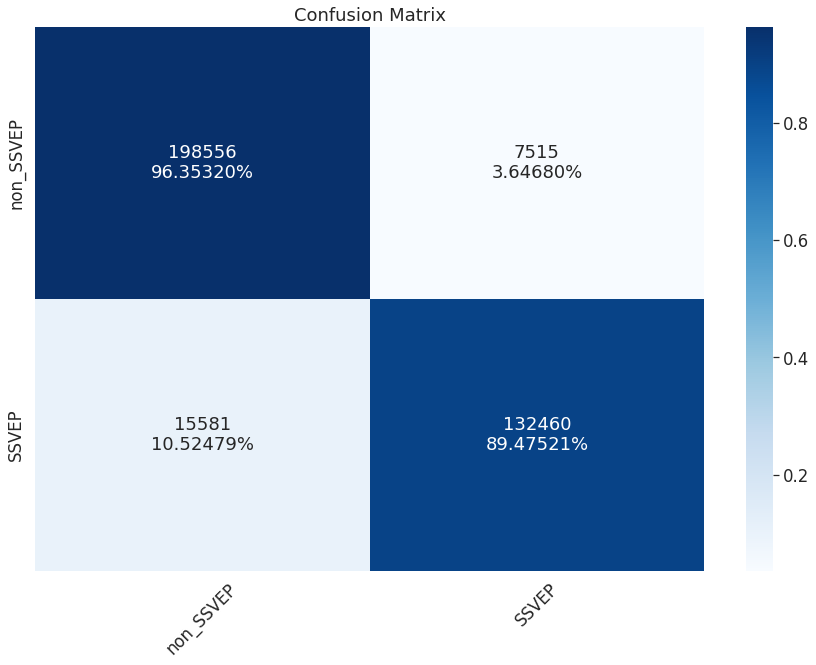

In [35]:
gesture_list=np.unique(y_task)
utils.plot_confusion_matrix(y_task.reshape(-1,1), y_pred_task.reshape(-1,1), ['non_SSVEP', 'SSVEP'], params['model_checkpoint_path'])

test_precision_task=precision_score(y_task, y_pred_task, pos_label='positive', average='macro')
test_recall_task=recall_score(y_task, y_pred_task, pos_label='positive',average='macro')
test_f1_score_task=f1_score(y_task, y_pred_task,average='macro')

print(classification_report(y_task,y_pred_task,target_names=[str(x) for x in ['non_SSVEP', 'SSVEP']]))
print("Accuracy Score :", accuracy_score(y_task,y_pred_task))
print("Precision Score :",test_precision_task)
print("Recall Score :",test_recall_task)
print("F1-Score :",test_f1_score_task)